In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from datetime import datetime
from scipy.integrate import odeint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import json
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
torch.set_default_device(device)
torch.set_default_dtype(torch.float64)
print("Setting default device to: ", device)
from PINN import CausalTrainingGradientBalancingODePINN, OdePINN, MLP_UModel, ThetaModel, LorenzThetaModel, LorenzOdePINN
from PINNModels import MLP, LambdaLayer, ConstantVariable, LearnableVariable

Setting default device to:  cuda
Setting default device to:  cuda
Setting default device to:  cuda


# Simulation Setup

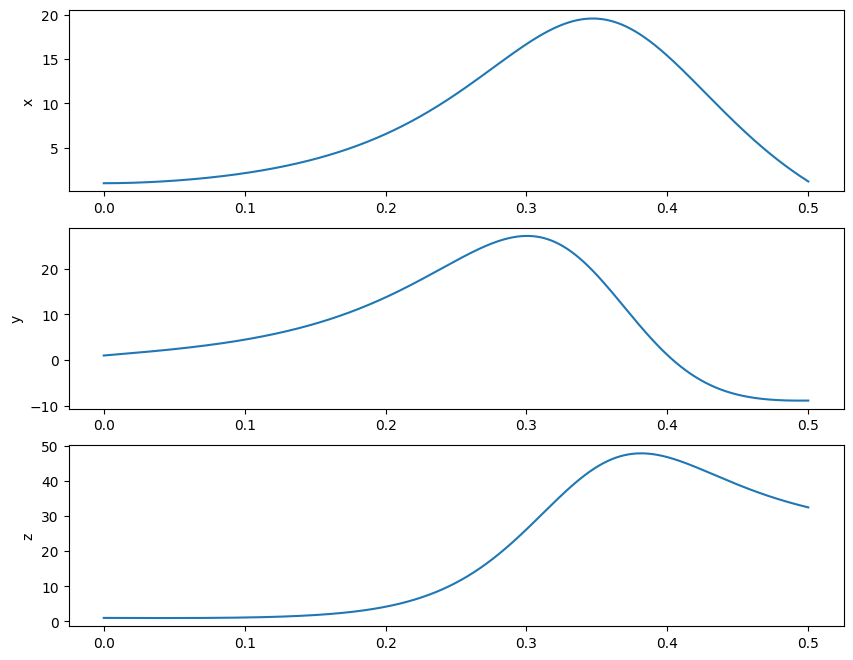

In [2]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt


# Define the system of equations for numerical solution
def system(u, t, ):
    sigma, rho, beta = 10, 28, 8/3
    x, y, z = u
    return sigma * (y - x), x * (rho -  z) - y, x * y - beta * z

t_range = np.linspace(0, 0.5, 40*1000+1)

simulate_data = odeint(func=system, y0=[1.0, 1.0, 1.0], t=t_range)

# subplot for each variable
plt.figure(figsize=(10, 8))
plt.subplot(311)
plt.plot(t_range, simulate_data[:, 0])
plt.ylabel('x')
plt.subplot(312)
plt.plot(t_range, simulate_data[:, 1])
plt.ylabel('y')
plt.subplot(313)
plt.plot(t_range, simulate_data[:, 2])
plt.ylabel('z')
plt.show()

u_data = simulate_data

# Forward

## [0, 2.0]

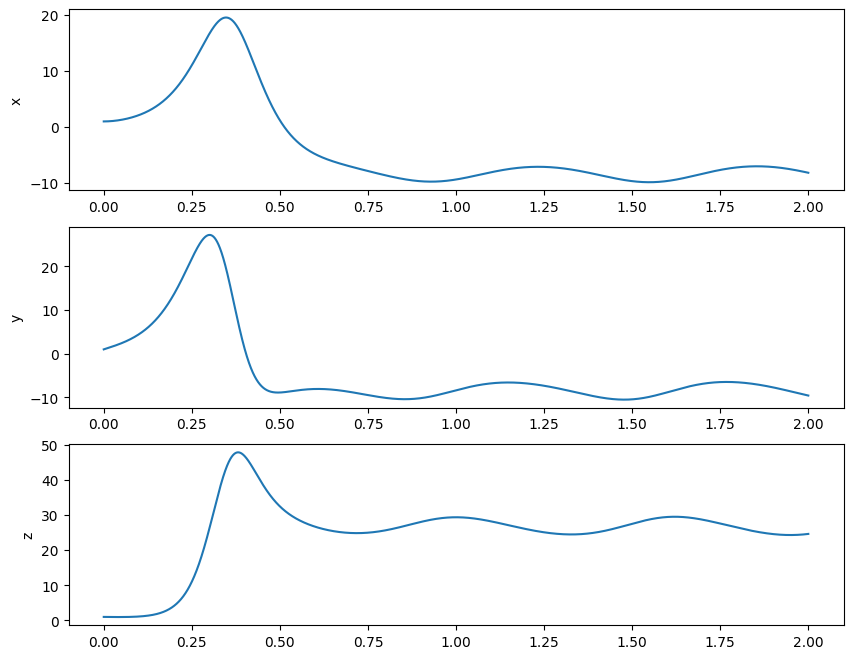

In [3]:


# Define the system of equations for numerical solution
def system(u, t, ):
    sigma, rho, beta = 10, 28, 8/3
    x, y, z = u
    return sigma * (y - x), x * (rho -  z) - y, x * y - beta * z

t_range = np.linspace(0, 2.0, 40*1000+1)

simulate_data = odeint(func=system, y0=[1.0, 1.0, 1.0], t=t_range)

# subplot for each variable
plt.figure(figsize=(10, 8))
plt.subplot(311)
plt.plot(t_range, simulate_data[:, 0])
plt.ylabel('x')
plt.subplot(312)
plt.plot(t_range, simulate_data[:, 1])
plt.ylabel('y')
plt.subplot(313)
plt.plot(t_range, simulate_data[:, 2])
plt.ylabel('z')
plt.show()

u_data = simulate_data

In [14]:
checkpoint_list = [
    "checkpoints/PINN_Lorenz_forward_orig/model_final.pt",
    "checkpoints/PINN_Lorenz_forward_baseline/model_final.pt",
    "checkpoints/PINN_Lorenz_forward_grad/model_final.pt",
    "checkpoints/PINN_Lorenz_forward_causal/model_final.pt",
    "checkpoints/PINN_Lorenz_forward_gradcausal/model_final.pt",
]


t_pred = torch.linspace(0, 2.0, 1000).reshape(-1, 1)
MODELS = []
list_u_pred = []
for ii, (model_name, checkpoint_path) in enumerate(zip(["orig", "baseline", "grad", "causal", "gradcausal"],checkpoint_list)):

    U_domain = [torch.min(torch.tensor(u_data), axis=0).values, torch.max(torch.tensor(u_data), axis=0).values]
    U_domain_mean = (U_domain[0] + U_domain[1]) / 2
    U_domain[0] = torch.minimum(U_domain_mean - 1.0, U_domain[0])
    U_domain[1] = torch.maximum(U_domain_mean + 1.0, U_domain[1])

    lorenz_pinn = LorenzOdePINN(T_domain=[0.0, 2.0],
                                    U_domain=U_domain if model_name != "orig" else None,
                                    u_data=[torch.tensor([[0.0]]), torch.tensor([[1.0, 1.0, 1.0]])],
                                    lambda_alpha=0.99, 
                                    lambda_update=None, 
                                    n_gradual_steps=0, 
                                    n_warmup_steps=0, 
                                    checkpoint_dir=None)

    lorenz_pinn.load_model(checkpoint_path)

    u_pred = lorenz_pinn.predict_u(t_pred)
    u_pred = u_pred.detach().cpu().numpy()
    list_u_pred.append(u_pred)

    MODELS.append(lorenz_pinn)
t_pred = t_pred.detach().cpu().numpy()

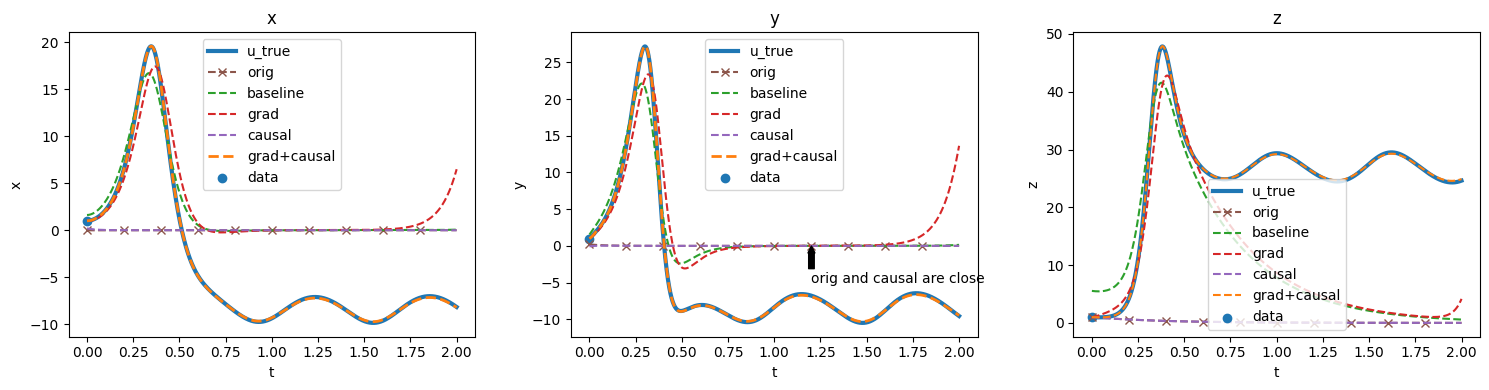

In [15]:



# Using subplots with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(t_range, simulate_data[:, 0], "-",label='u_true', color='#1f77b4', linewidth=3)
axs[0].plot(t_pred, list_u_pred[0][:, 0], "--", label="orig", color='#8c564b', markevery=100, marker='x')
axs[0].plot(t_pred, list_u_pred[1][:, 0], "--", label="baseline", color='#2ca02c')
axs[0].plot(t_pred, list_u_pred[2][:, 0], "--", label="grad", color='#d62728')
axs[0].plot(t_pred, list_u_pred[3][:, 0], "--", label="causal", color='#9467bd')
axs[0].plot(t_pred, list_u_pred[4][:, 0], "--", label="grad+causal", color='#ff7f0e', linewidth=2)
axs[0].scatter(t_pred[0, 0], u_data[0, 0], color='#1f77b4', label='data')

axs[0].set_xlabel('t')
axs[0].set_ylabel('x')
axs[0].set_title('x')
axs[0].legend()

# y
axs[1].plot(t_range, simulate_data[:, 1], label='u_true', color='#1f77b4', linewidth=3)
axs[1].plot(t_pred, list_u_pred[0][:, 1], "--", label="orig", color='#8c564b', markevery=100, marker='x')
axs[1].plot(t_pred, list_u_pred[1][:, 1], "--", label="baseline", color='#2ca02c')
axs[1].plot(t_pred, list_u_pred[2][:, 1], "--", label="grad", color='#d62728')
axs[1].plot(t_pred, list_u_pred[3][:, 1], "--", label="causal", color='#9467bd')
axs[1].plot(t_pred, list_u_pred[4][:, 1], "--", label="grad+causal", color='#ff7f0e', linewidth=2)
axs[1].scatter(t_pred[0, 0], u_data[0, 1], color='#1f77b4', label='data')
axs[1].annotate('orig and causal are close', xy=(t_pred[600], list_u_pred[3][600, 1]), xytext=(t_pred[600], list_u_pred[3][600, 1]-5),
             arrowprops=dict(facecolor='black', shrink=0.005, headwidth=5, headlength=5))
axs[1].set_xlabel('t')
axs[1].set_ylabel('y')
axs[1].set_title('y')
axs[1].legend()

# z
axs[2].plot(t_range, simulate_data[:, 2], label='u_true', color='#1f77b4', linewidth=3)
axs[2].plot(t_pred, list_u_pred[0][:, 2], "--", label="orig", color='#8c564b', markevery=100, marker='x')
axs[2].plot(t_pred, list_u_pred[1][:, 2], "--", label="baseline", color='#2ca02c')
axs[2].plot(t_pred, list_u_pred[2][:, 2], "--", label="grad", color='#d62728')
axs[2].plot(t_pred, list_u_pred[3][:, 2], "--", label="causal", color='#9467bd')
axs[2].plot(t_pred, list_u_pred[4][:, 2], "--", label="grad+causal", color='#ff7f0e')
axs[2].scatter(t_pred[0, 0], u_data[0, 2], color='#1f77b4', label='data')
axs[2].set_xlabel('t')
axs[2].set_ylabel('z')
axs[2].set_title('z')
axs[2].legend()

plt.tight_layout()
plt.show()

In [ ]:
lorenz_pinn = MODELS[1]
t_pred = torch.linspace(0, 2.0, 1000).reshape(-1, 1)
u_pred = lorenz_pinn.predict_u(t_pred)

t_pred = t_pred.detach().cpu().numpy()
u_pred = u_pred.detach().cpu().numpy()

# Using subplots with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(t_range, simulate_data[:, 0], label='x_true')
axs[0].plot(t_pred, u_pred[:, 0], "--", label='x_pred')
axs[0].set_ylabel('x')
axs[0].legend()

axs[1].plot(t_range, simulate_data[:, 1], label='y_true')
axs[1].plot(t_pred, u_pred[:, 1], "--", label='y_pred')
axs[1].set_ylabel('y')
axs[1].legend()

axs[2].plot(t_range, simulate_data[:, 2], label='z_true')
axs[2].plot(t_pred, u_pred[:, 2], "--", label='z_pred')
axs[2].set_ylabel('z')
axs[2].legend()

plt.tight_layout()
plt.show()

## [0, 20.0]

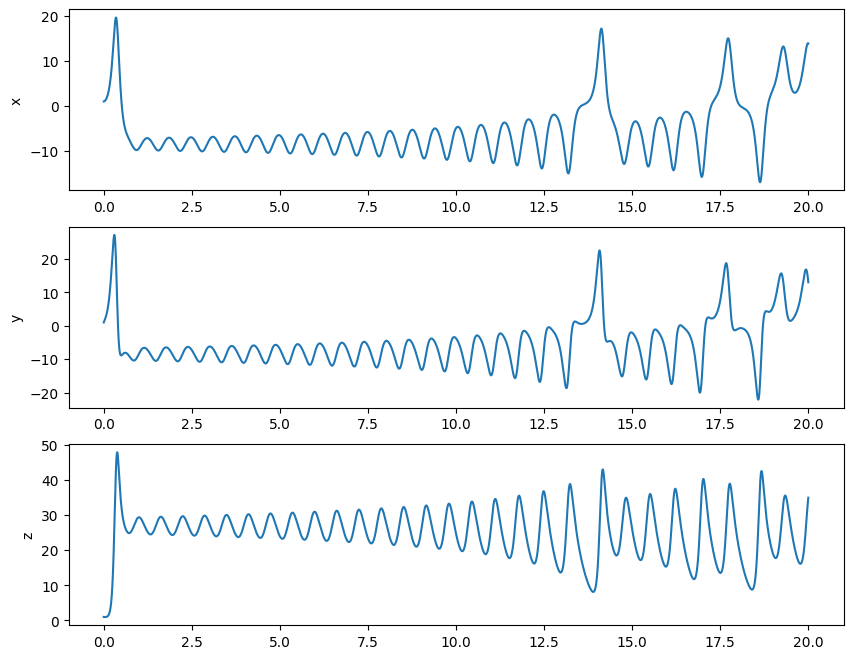

In [19]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt


# Define the system of equations for numerical solution
def system(u, t, ):
    sigma, rho, beta = 10, 28, 8/3
    x, y, z = u
    return sigma * (y - x), x * (rho -  z) - y, x * y - beta * z

t_range = np.linspace(0, 20.0, 40*100000+1)

simulate_data = odeint(func=system, y0=[1.0, 1.0, 1.0], t=t_range)

# subplot for each variable
plt.figure(figsize=(10, 8))
plt.subplot(311)
plt.plot(t_range, simulate_data[:, 0])

plt.ylabel('x')
plt.subplot(312)
plt.plot(t_range, simulate_data[:, 1])
plt.ylabel('y')
plt.subplot(313)
plt.plot(t_range, simulate_data[:, 2])
plt.ylabel('z')
plt.show()

u_data = simulate_data
t_data = t_range

u_data = torch.tensor(u_data)
t_data = torch.tensor(t_data)

In [18]:
n_subdomains = 40
global_T_domain = [t_data.min(), t_data.max()]
subdomain_size = (global_T_domain[1] - global_T_domain[0]) / n_subdomains
overlap_size = 0.1 * subdomain_size
print(global_T_domain, subdomain_size, overlap_size)

t_init = torch.tensor([[0.0]])
u_init = torch.tensor([[1.0, 1.0, 1.0]])
MODELS = []
for i in range(n_subdomains):
    checkpoint_dir = f"checkpoints/PINN_Lorenz_forward_gradcausaldomain_subdomain_{i}"

    if checkpoint_dir is not None:
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)

    T_training_subdomain = [global_T_domain[0] + i * subdomain_size - overlap_size, global_T_domain[0] + (i+1) * subdomain_size + overlap_size]
    T_training_subdomain[0] = max(T_training_subdomain[0], global_T_domain[0])
    T_training_subdomain[1] = min(T_training_subdomain[1], global_T_domain[1])
    T_prediction_subdomain = [global_T_domain[0] + i * subdomain_size, global_T_domain[0] + (i+1) * subdomain_size]
    T_prediction_subdomain[0] = max(T_prediction_subdomain[0], global_T_domain[0])
    T_prediction_subdomain[1] = min(T_prediction_subdomain[1], global_T_domain[1])

    t_data_subdomain = t_data[((t_data >= T_training_subdomain[0]) & (t_data <= T_training_subdomain[1])).reshape(-1)]
    u_data_subdomain = u_data[((t_data >= T_training_subdomain[0]) & (t_data <= T_training_subdomain[1])).reshape(-1)]
    U_subdomain = [u_data_subdomain.min(axis=0).values, u_data_subdomain.max(axis=0).values]
    U_subdomain_mean = (U_subdomain[0] + U_subdomain[1]) / 2
    U_subdomain[0] = torch.minimum(U_subdomain_mean - 1.0, U_subdomain[0])
    U_subdomain[1] = torch.maximum(U_subdomain_mean + 1.0, U_subdomain[1])

    print("Subdomain: ", i)
    print("Training domain: ", T_training_subdomain)
    print("Prediction domain: ", T_prediction_subdomain)

    lorenz_pinn = LorenzOdePINN(T_domain=T_training_subdomain,
                                    U_domain=U_subdomain,
                                    u_data=[t_init, u_init],
                                    lambda_alpha=0.99, 
                                    lambda_update=100, 
                                    n_gradual_steps=210000, 
                                    n_warmup_steps=10000, 
                                    checkpoint_dir=checkpoint_dir)
    
    if checkpoint_dir is None or not os.path.exists(os.path.join(checkpoint_dir, 'model_final.pt')):
        logs = lorenz_pinn.train(n_steps=300000,
                            n_epoches_per_evaluation=100,
                            n_patience=100,)
    else:
        lorenz_pinn.load_model(os.path.join(checkpoint_dir, 'model_final.pt'))
        MODELS.append([lorenz_pinn, T_prediction_subdomain])
    print("Overlap", T_prediction_subdomain[1] - overlap_size, T_training_subdomain[1])
    print()
    t_init = torch.linspace(T_prediction_subdomain[1] - overlap_size, T_training_subdomain[1], 100).view(-1, 1)
    u_init = lorenz_pinn.predict_u(t_init).detach()

[tensor(0., device='cuda:0'), tensor(20., device='cuda:0')] tensor(0.5000, device='cuda:0') tensor(0.0500, device='cuda:0')
Subdomain:  0
Training domain:  [tensor(0., device='cuda:0'), tensor(0.5500, device='cuda:0')]
Prediction domain:  [tensor(0., device='cuda:0'), tensor(0.5000, device='cuda:0')]
Overlap tensor(0.4500, device='cuda:0') tensor(0.5500, device='cuda:0')

Subdomain:  1
Training domain:  [tensor(0.4500, device='cuda:0'), tensor(1.0500, device='cuda:0')]
Prediction domain:  [tensor(0.5000, device='cuda:0'), tensor(1., device='cuda:0')]
Overlap tensor(0.9500, device='cuda:0') tensor(1.0500, device='cuda:0')

Subdomain:  2
Training domain:  [tensor(0.9500, device='cuda:0'), tensor(1.5500, device='cuda:0')]
Prediction domain:  [tensor(1., device='cuda:0'), tensor(1.5000, device='cuda:0')]
Overlap tensor(1.4500, device='cuda:0') tensor(1.5500, device='cuda:0')

Subdomain:  3
Training domain:  [tensor(1.4500, device='cuda:0'), tensor(2.0500, device='cuda:0')]
Prediction domai

In [20]:
list_u_pred = []
list_t_pred = []
list_u_ref = []
list_data_loss = []
list_ode_loss = []
for ii, (lorenz_pinn, T_domain) in enumerate(MODELS):
    t_data_subdomain = t_data[((t_data >= T_domain[0]) & (t_data < T_domain[1]))].reshape(-1,1)
    u_data_subdomain = u_data[((t_data >= T_domain[0]) & (t_data < T_domain[1]))]
    if ii == len(MODELS) - 1:
        t_data_subdomain = t_data[((t_data >= T_domain[0]) & (t_data <= T_domain[1]))].reshape(-1,1)
        u_data_subdomain = u_data[((t_data >= T_domain[0]) & (t_data <= T_domain[1]))]
    u_pred_subdomain = lorenz_pinn.predict_u(t_data_subdomain).detach().cpu().numpy()

    ode_equations = lorenz_pinn.ode_equations(torch.tensor(t_data_subdomain, requires_grad=True))
    ode_losses = torch.sqrt(torch.mean(torch.square(torch.hstack(ode_equations)),axis=1))
    ode_losses = ode_losses.detach().cpu().numpy()

    tt, uu = lorenz_pinn.u_data_fn()
    uu_pred = lorenz_pinn.u_model.forward(tt)
    uu = lorenz_pinn.u_model.output_norm_fn(uu)
    data_losses = torch.sqrt(torch.mean((uu - uu_pred)**2, axis=1))
    tt = tt.detach().cpu().numpy()
    data_losses = data_losses.detach().cpu().numpy()

    list_u_pred.append(u_pred_subdomain)
    list_t_pred.append(t_data_subdomain.detach().cpu().numpy())
    list_u_ref.append(u_data_subdomain.detach().cpu().numpy())
    list_data_loss.append([tt, data_losses])
    list_ode_loss.append(ode_losses)
    
u_pred = np.concatenate(list_u_pred, axis=0)
t_pred = np.concatenate(list_t_pred, axis=0)
u_ref = np.concatenate(list_u_ref, axis=0)
data_loss = np.stack([np.concatenate([s[0] for s in list_data_loss]).reshape(-1) ,
          np.concatenate([s[1] for s in list_data_loss])], axis=1)
ode_loss = np.concatenate(list_ode_loss, axis=0)

In [26]:
x_points = [T_domain[0].item() for _, T_domain in MODELS] + [MODELS[-1][1][1].item()]
overlap_points = [(T_domain[1].item() - overlap_size.item(), T_domain[1].item() + overlap_size.item()) for _, T_domain in MODELS]
overlap_points = np.asarray(overlap_points)[:-1]
# overlap_points

t_true = t_data.detach().cpu().numpy()
u_true = u_data.detach().cpu().numpy()

errors = np.mean(np.abs(u_ref - u_pred), axis=1)

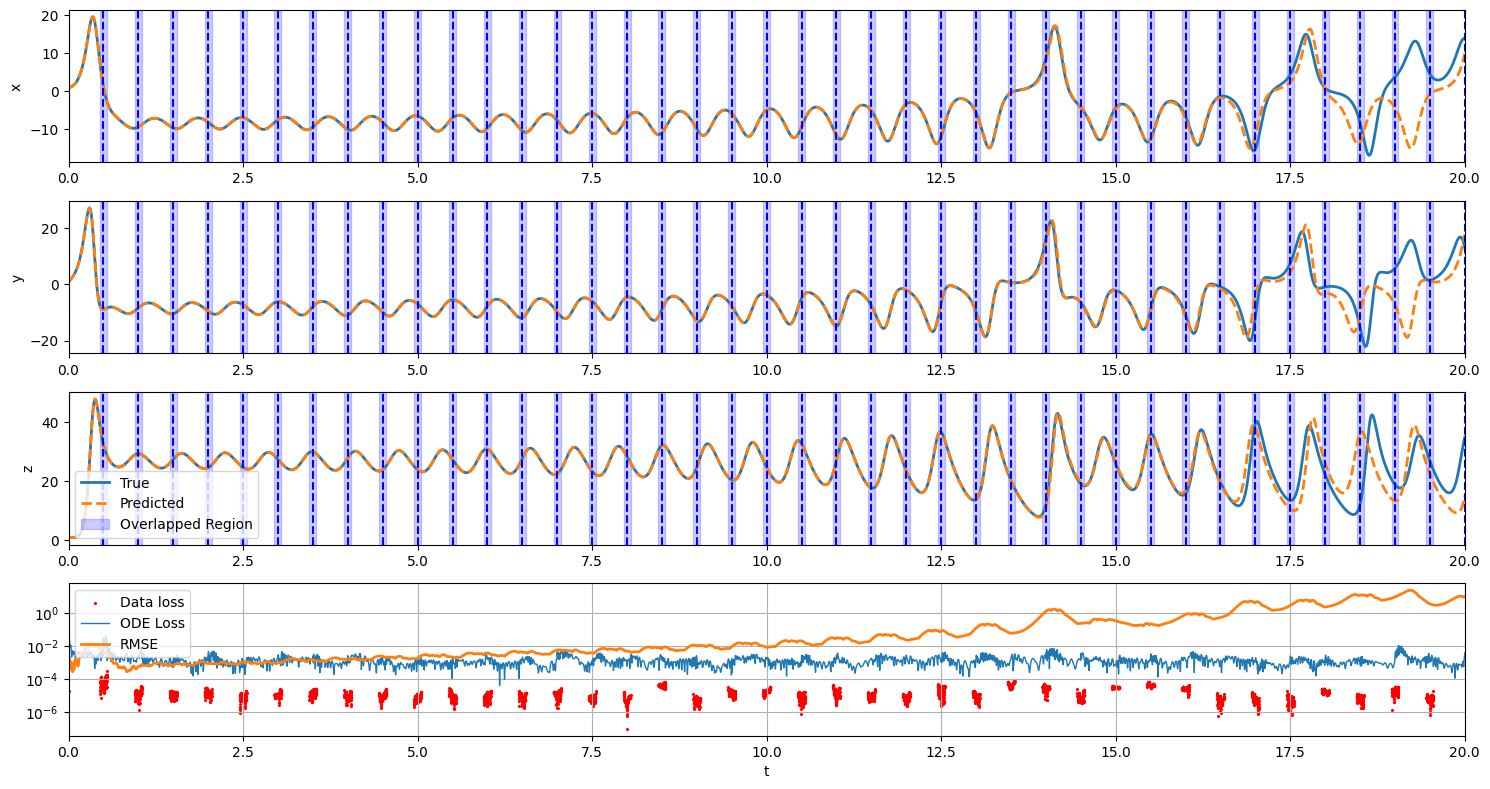

In [27]:
plt.figure(figsize=(15, 8))  # Adjusting figure size for better visibility of vertical plots
plt.subplot(4, 1, 1)  # First row for the first variable
plt.plot(t_true[::1000], u_true[:, 0][::1000], label='True', linewidth=2)
plt.plot(t_pred[::1000], u_pred[:, 0][::1000], "--", label='Predicted', linewidth=2)
for x in x_points:
    plt.axvline(x=x, color='b', linestyle='--',)
for x1, x2 in overlap_points:
    plt.axvspan(x1, x2, color='blue', alpha=0.2)
plt.ylabel('x')
plt.xlim([0, 20])
# plt.legend()

plt.subplot(4, 1, 2)  # Second row for the second variable
plt.plot(t_true[::1000], u_true[:, 1][::1000], label='True', linewidth=2)
plt.plot(t_pred[::1000], u_pred[:, 1][::1000], "--", label='Predicted', linewidth=2)
for x in x_points:
    plt.axvline(x=x, color='b', linestyle='--',)
for x1, x2 in overlap_points:
    plt.axvspan(x1, x2, color='blue', alpha=0.2)
plt.ylabel('y')
plt.xlim([0, 20])
# plt.legend()

plt.subplot(4, 1, 3)  # Third row for the third variable
plt.plot(t_true[::1000], u_true[:, 2][::1000], label='True', linewidth=2)
plt.plot(t_pred[::1000], u_pred[:, 2][::1000], "--", label='Predicted', linewidth=2)
for x in x_points:
    plt.axvline(x=x, color='b', linestyle='--',)
for ii, (x1, x2) in enumerate(overlap_points):
    plt.axvspan(x1, x2, color='blue', alpha=0.2, label="Overlapped Region" if ii == 0 else None)
plt.ylabel('z')
plt.xlim([0, 20])
plt.legend(loc="lower left")

plt.subplot(4, 1, 4) # plot errors

plt.scatter(data_loss[:, 0], data_loss[:, 1], s=2, marker="x", color='red', label='Data loss',)
plt.plot(t_pred[::1000], ode_loss[::1000], label='ODE Loss', linewidth=1,)
plt.plot(t_pred[::1000], errors[::1000], label='RMSE', linewidth=2,)
plt.xlim([0, 20])
plt.yscale('log')
plt.xlabel("t")
plt.legend()
plt.tight_layout()  # This will make sure the plots do not overlap
plt.grid()
plt.show()


# END